In [163]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-games-dataset/games_may2024_cleaned.csv
/kaggle/input/steam-games-dataset/games_may2024_full.csv
/kaggle/input/steam-games-dataset/games_march2025_full.csv
/kaggle/input/steam-games-dataset/games_march2025_cleaned.csv


In [164]:
df = pd.read_csv('/kaggle/input/steam-games-dataset/games_march2025_full.csv')

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     94948 non-null  int64  
 1   name                      94946 non-null  object 
 2   release_date              94948 non-null  object 
 3   required_age              94948 non-null  int64  
 4   price                     94948 non-null  float64
 5   dlc_count                 94948 non-null  int64  
 6   detailed_description      89522 non-null  object 
 7   about_the_game            89499 non-null  object 
 8   short_description         89599 non-null  object 
 9   reviews                   10428 non-null  object 
 10  header_image              94948 non-null  object 
 11  website                   41194 non-null  object 
 12  support_url               44185 non-null  object 
 13  support_email             78848 non-null  object 
 14  window

In [166]:
# worthy to drop the following features
# most of them are entirely missing
# and eventually causing noise
# notes, support_url, support_email, website
# they are string identifiers/URLs 
# not very useful for XGBoost
# unless we want to establish publisher contact

In [167]:
df = df.drop(columns=['metacritic_url', 'score_rank', 'reviews', 'notes', 'website', 'support_url', 'support_email'], axis=1)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     94948 non-null  int64  
 1   name                      94946 non-null  object 
 2   release_date              94948 non-null  object 
 3   required_age              94948 non-null  int64  
 4   price                     94948 non-null  float64
 5   dlc_count                 94948 non-null  int64  
 6   detailed_description      89522 non-null  object 
 7   about_the_game            89499 non-null  object 
 8   short_description         89599 non-null  object 
 9   header_image              94948 non-null  object 
 10  windows                   94948 non-null  bool   
 11  mac                       94948 non-null  bool   
 12  linux                     94948 non-null  bool   
 13  metacritic_score          94948 non-null  int64  
 14  achiev

In [169]:
# less to moderate missing values in 
# detailed_description 
# about_the_game
# short_description 

# so, these seems to be long text descriptions
# not worthy when I just want to apply xgboost
# and other ML algorithms

# our goal for now is not NLP but classic 
# classification and regression, so yes, let's go

In [170]:
df = df.drop(columns=['detailed_description', 'about_the_game', 'short_description'], axis=1)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     94948 non-null  int64  
 1   name                      94946 non-null  object 
 2   release_date              94948 non-null  object 
 3   required_age              94948 non-null  int64  
 4   price                     94948 non-null  float64
 5   dlc_count                 94948 non-null  int64  
 6   header_image              94948 non-null  object 
 7   windows                   94948 non-null  bool   
 8   mac                       94948 non-null  bool   
 9   linux                     94948 non-null  bool   
 10  metacritic_score          94948 non-null  int64  
 11  achievements              94948 non-null  int64  
 12  recommendations           94948 non-null  int64  
 13  supported_languages       94948 non-null  object 
 14  full_a

let's one by one talk about objects features "genres", "categories" and "tags" they influence a game's success by guiding player choices,developer decisions and market strategies. they help players find games they will enjoy
inform development decisions, 
and in targeted marketing campaigns

so, i am deciding to keeping them, they seem gold!

then we have "publishers" and "developers" as publishers primarily focus on marketing or promotion and distribution while developers handle the core game creation and development 
so, success rate depends on them alot

game packages, hold both physical packaging and digital formats, play an important role in a game's success by influencing appeal marketing and long-term engagement



In [172]:
df = df.drop(columns=['movies', 'screenshots', 'header_image'])

header_image, screenshots and movies do not hold numeric/tabular features, they are basically links(urls) to the media content. so, not a need to keep as we are not doing computer vision/deep learning yet. 

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     94948 non-null  int64  
 1   name                      94946 non-null  object 
 2   release_date              94948 non-null  object 
 3   required_age              94948 non-null  int64  
 4   price                     94948 non-null  float64
 5   dlc_count                 94948 non-null  int64  
 6   windows                   94948 non-null  bool   
 7   mac                       94948 non-null  bool   
 8   linux                     94948 non-null  bool   
 9   metacritic_score          94948 non-null  int64  
 10  achievements              94948 non-null  int64  
 11  recommendations           94948 non-null  int64  
 12  supported_languages       94948 non-null  object 
 13  full_audio_languages      94948 non-null  object 
 14  packag

In [174]:
df['packages'].unique()

array(["[{'title': 'Buy Counter-Strike 2', 'description': '', 'subs': [{'text': 'Counter-Strike 2 - Free', 'description': '', 'price': 0.0}, {'text': 'Prime Status Upgrade - $14.99', 'description': '', 'price': 14.99}]}]",
       '[]',
       "[{'title': 'Buy Dota 2', 'description': '', 'subs': [{'text': 'Dota 2 - Commercial License - Free', 'description': '', 'price': 0.0}]}]",
       ...,
       "[{'title': 'Buy Player One', 'description': '', 'subs': [{'text': 'Player One - $1.99', 'description': '', 'price': 1.99}]}]",
       "[{'title': 'Buy DragonRoad', 'description': '', 'subs': [{'text': 'DragonRoad - $29.99', 'description': '', 'price': 29.99}]}]",
       "[{'title': 'Buy Ragtag Adventurers', 'description': '', 'subs': [{'text': 'Ragtag Adventurers - $9.99', 'description': '', 'price': 9.99}]}]"],
      dtype=object)

i am not going to throw packages away, it seems a goldmine to me. 

"[{'title': 'Buy Counter-Strike 2', 'description': '', 'subs': [{'text': 'Counter-Strike 2 - Free', 'description': '', 'price': 0.0}, {'text': 'Prime Status Upgrade - $14.99', 'description': '', 'price': 14.99}]}]"

here, as we can see sub packages and they are basically editions to me.

we have
1. num_subs = 2 (numbe of sub packages)(int) 
2. minimum_price = 0(free)(float)
3. maximum_price = 14.99(float)
4. has_free_version = 1(bool)

let's do it now 

In [175]:
import pandas as pd
import ast 
import numpy as np

def extract_package_features(package_data):
    # default features
    num_subpackages = 0
    minimum_price = np.nan
    maximum_price = np.nan
    has_free_version = 0
    num_free = 0
    num_paid = 0

    try: 
        # safely parse string into python object
        packages = ast.literal_eval(package_data)
        # it evaluate the data containing python literal 

        if isinstance(packages, list) and len(packages) > 0: 
            # checking if the parsed object is a list and not empty 
            subs = packages[0].get("subs", [])
            prices = [sub.get("price", np.nan) for sub in subs]

            if prices: 
                num_subpackages = len(prices)
                minimum_price = min(prices)
                maximum_price = max(prices)
                num_free = sum(1 for p in prices if p == 0.0)
                num_paid = num_subpackages - num_free
                has_free_version = int(num_free > 0)

    except (ValueError, SyntaxError): 
        pass

    return num_subpackages, minimum_price, maximum_price,has_free_version, num_free, num_paid
                

In [176]:
extract_package_features(df['packages'].iloc[0])

(2, 0.0, 14.99, 1, 1, 1)

now, let's apply this to all the rows

In [177]:
df[["number_of_subpackages", "minimum_price", "maximum_price", "has_free_version", "number_of_free_edition", "number_of_paid_edition"]] = (
    df["packages"].apply(lambda x : pd.Series(extract_package_features(x)))
)

In [178]:
df['maximum_price'] = df['maximum_price'].fillna(0)

In [179]:
df['minimum_price'] = df['minimum_price'].fillna(0)

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     94948 non-null  int64  
 1   name                      94946 non-null  object 
 2   release_date              94948 non-null  object 
 3   required_age              94948 non-null  int64  
 4   price                     94948 non-null  float64
 5   dlc_count                 94948 non-null  int64  
 6   windows                   94948 non-null  bool   
 7   mac                       94948 non-null  bool   
 8   linux                     94948 non-null  bool   
 9   metacritic_score          94948 non-null  int64  
 10  achievements              94948 non-null  int64  
 11  recommendations           94948 non-null  int64  
 12  supported_languages       94948 non-null  object 
 13  full_audio_languages      94948 non-null  object 
 14  packag

In [181]:
df['genres'].values

array(["['Action', 'Free To Play']",
       "['Action', 'Adventure', 'Massively Multiplayer', 'Free To Play']",
       "['Action', 'Strategy', 'Free To Play']", ...,
       "['Indie', 'Early Access']",
       "['Adventure', 'RPG', 'Simulation', 'Strategy']",
       "['Action', 'Indie']"], dtype=object)

In [182]:
df['categories'].values

array(["['Multi-player', 'Cross-Platform Multiplayer', 'Steam Trading Cards', 'Steam Workshop', 'In-App Purchases', 'Valve Anti-Cheat enabled', 'Stats', 'Remote Play on Phone', 'Remote Play on Tablet', 'Remote Play on TV', 'Steam Timeline']",
       "['Multi-player', 'PvP', 'Online PvP', 'Stats', 'Remote Play on Phone', 'Remote Play on Tablet']",
       "['Multi-player', 'Co-op', 'Steam Trading Cards', 'Steam Workshop', 'SteamVR Collectibles', 'In-App Purchases', 'Valve Anti-Cheat enabled', 'Steam Timeline']",
       ..., "['Single-player', 'Family Sharing']",
       "['Single-player', 'Multi-player', 'PvP', 'Online PvP', 'Co-op', 'Online Co-op', 'Steam Achievements', 'Full controller support', 'Captions available', 'Steam Cloud', 'Stats', 'Steam Leaderboards', 'Remote Play on TV', 'Remote Play Together', 'Family Sharing']",
       "['Single-player', 'Multi-player', 'PvP', 'Online PvP', 'Shared/Split Screen PvP', 'Co-op', 'Online Co-op', 'Shared/Split Screen Co-op', 'Shared/Split Scree

it is stored as a stringified python list. which is enough of a hustle. 

solution is 
1. parse the string into a real python list
2. now converting it into multi-hot encoded features

In [183]:
df['categories'] = df['categories'].apply(lambda x : ast.literal_eval(x) if pd.notnull(x) else [])

In [184]:
df['categories']

0        [Multi-player, Cross-Platform Multiplayer, Ste...
1        [Multi-player, PvP, Online PvP, Stats, Remote ...
2        [Multi-player, Co-op, Steam Trading Cards, Ste...
3        [Single-player, Multi-player, PvP, Online PvP,...
4        [Single-player, Multi-player, PvP, Online PvP,...
                               ...                        
94943    [Single-player, Steam Achievements, Stats, Ste...
94944                      [Single-player, Family Sharing]
94945                      [Single-player, Family Sharing]
94946    [Single-player, Multi-player, PvP, Online PvP,...
94947    [Single-player, Multi-player, PvP, Online PvP,...
Name: categories, Length: 94948, dtype: object

converting into multi-hot encoded features

In [185]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(df['categories'])

df_categories = pd.DataFrame(categories_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_categories], axis=1)

In [186]:
df = df.drop(columns = ['categories'])

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   appid                       94948 non-null  int64  
 1   name                        94946 non-null  object 
 2   release_date                94948 non-null  object 
 3   required_age                94948 non-null  int64  
 4   price                       94948 non-null  float64
 5   dlc_count                   94948 non-null  int64  
 6   windows                     94948 non-null  bool   
 7   mac                         94948 non-null  bool   
 8   linux                       94948 non-null  bool   
 9   metacritic_score            94948 non-null  int64  
 10  achievements                94948 non-null  int64  
 11  recommendations             94948 non-null  int64  
 12  supported_languages         94948 non-null  object 
 13  full_audio_languages        949

In [188]:
df['tags'].unique()

array(["{'FPS': 90857, 'Shooter': 65397, 'Multiplayer': 62332, 'Competitive': 53359, 'Action': 47512, 'Team-Based': 46430, 'e-sports': 43533, 'Tactical': 41354, 'First-Person': 39414, 'PvP': 34470, 'Online Co-Op': 33966, 'Co-op': 30263, 'Strategy': 30111, 'Military': 28699, 'War': 28006, 'Difficult': 25966, 'Trading': 25717, 'Realistic': 25430, 'Fast-Paced': 25318, 'Moddable': 6603}",
       "{'Survival': 14838, 'Shooter': 12727, 'Battle Royale': 10877, 'Multiplayer': 10837, 'FPS': 8428, 'PvP': 7703, 'Third-Person Shooter': 7322, 'Action': 6013, 'Online Co-Op': 5368, 'Tactical': 5058, 'Co-op': 4336, 'First-Person': 4090, 'Strategy': 3121, 'Early Access': 2829, 'Competitive': 2437, 'Third Person': 2369, 'Team-Based': 2090, 'Difficult': 1750, 'Simulation': 1390, 'Stealth': 1297}",
       "{'Free to Play': 59933, 'MOBA': 20158, 'Multiplayer': 15359, 'Strategy': 14252, 'e-sports': 11780, 'Team-Based': 10962, 'Competitive': 8286, 'Action': 7920, 'Online Co-Op': 7464, 'PvP': 6046, 'Difficult

dictionary stored as a string for each game. keys are tags and values is the number of times players applied the tag(tag frequency/popularity), they hold weights(counts), not just presence but how strongly the community associates with the game with the tag, so information rich feature. 


1. so,the idea is that we pick up the top N tags and compute their frequency, it avoids alot of useless information.
2. weighted features, for each game, create a feature column for each top-N tag.
3. if tag not present, is 0 else the value.
4. other tags in another column, simple.
5. dropping the original string tags after extraction. 

In [189]:
from collections import Counter

# 1. parse tags column from string to dictionary 
def parse_tags(tag_string): 
    try: 
        parsed = ast.literal_eval(tag_string)
        # parsing the tag_string 
        # checking if it is a list now
        if isinstance(parsed, list): 
            merged = {}
            for d in parsed: 
                if isinstance(d, dict): 
                    merged.update(d)
            return merged
        elif isinstance(parsed, dict): 
            return parsed
        else: 
            return {}
    except (ValueError, SyntaxError): 
        return {}

df['tags_dict'] = df['tags'].apply(parse_tags)

# 2. count overall frequency of all tags
all_tags = Counter() #to count occurrences of keys

for tags in df['tags_dict']: 
    all_tags.update(tags) #adds the count from that row to the total counter

# 3. pick top-N tags
Top_N = 50
top_tags = [tag for tag, count in all_tags.most_common(Top_N)] #to get most frequent one

# 4. create numeric columns for Top-N tags
for tag in top_tags: 
    df[f'tag_{tag}'] = df['tags_dict'].apply(lambda x: x.get(tag, 0))




In [190]:
df = df.drop(columns=['tags_dict', 'tags'])

In [191]:
df['genres'].unique()

array(["['Action', 'Free To Play']",
       "['Action', 'Adventure', 'Massively Multiplayer', 'Free To Play']",
       "['Action', 'Strategy', 'Free To Play']", ...,
       "['Action', 'Indie', 'Simulation', 'Education', 'Game Development']",
       "['Design & Illustration', 'Education', 'Game Development']",
       "['Violent', 'Action', 'Early Access']"], dtype=object)

genres are also stored as stringified lists. 


In [192]:
import ast 
from sklearn.preprocessing import MultiLabelBinarizer

# parse string to list 
df['genres_list'] = df['genres'].apply(lambda x : ast.literal_eval(x) if pd.notnull(x) else [])

# multi-hot encode
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres_list'])

df_genres = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_genres], axis=1)



In [193]:
df = df.drop(columns=['genres', 'genres_list'])

In [194]:
df.columns.tolist()

['appid',
 'name',
 'release_date',
 'required_age',
 'price',
 'dlc_count',
 'windows',
 'mac',
 'linux',
 'metacritic_score',
 'achievements',
 'recommendations',
 'supported_languages',
 'full_audio_languages',
 'packages',
 'developers',
 'publishers',
 'user_score',
 'positive',
 'negative',
 'estimated_owners',
 'average_playtime_forever',
 'average_playtime_2weeks',
 'median_playtime_forever',
 'median_playtime_2weeks',
 'discount',
 'peak_ccu',
 'pct_pos_total',
 'num_reviews_total',
 'pct_pos_recent',
 'num_reviews_recent',
 'number_of_subpackages',
 'minimum_price',
 'maximum_price',
 'has_free_version',
 'number_of_free_edition',
 'number_of_paid_edition',
 'Captions available',
 'Co-op',
 'Commentary available',
 'Cross-Platform Multiplayer',
 'Family Sharing',
 'Full controller support',
 'HDR available',
 'In-App Purchases',
 'Includes Source SDK',
 'Includes level editor',
 'LAN Co-op',
 'LAN PvP',
 'MMO',
 'Multi-player',
 'Online Co-op',
 'Online PvP',
 'Partial Contro

In [195]:
import ast 
df['publishers'] = df['publishers'].apply(lambda x : ast.literal_eval(x))

In [196]:
# explode publishers into separate rows
publishers_exploded = df[['appid', 'publishers']].explode('publishers')
# explode takes lists in a column and makes one row per item

# appid     publishers
# 1        ['Valve']
#2         ['Rockstar Games', 'Take-Two']
#3         []

# becomes
# appid    publishers
#1         Valve
#2         Rockstar Games
#3         Take-Two
#4         NaN

# we did this to make the counting publishers easier. 

# count frequencies of publishers
publishers_count = publishers_exploded['publishers'].value_counts()
# counts how many times each publisher appear
# across all games

# for example 
# Valve 120 
# Rockstar Games 85
# Electronic Arts 72
# Take-Two 65 ..... and it goes on and on. 

top_50_publishers = publishers_count.head(50).index.tolist()
# takes top 50 most common publishers. 

# create binary indicator columns 

for pub in top_50_publishers: 
    df[f'publisher_{pub}'] = df['publishers'].apply(lambda pubs : int(pub in pubs))

In [197]:
from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer(classes=top_50_publishers)
publishers_encoded = mlb.fit_transform(df['publishers'])

df_publishers = pd.DataFrame(publishers_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_publishers], axis=1)

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 260 entries, appid to Shiravune
dtypes: bool(3), float64(7), int64(242), object(8)
memory usage: 186.4+ MB


In [209]:
# df.columns.tolist()

developers, publishers

In [200]:
df = df.drop(columns=['publishers'], axis=1)

before moving further, may we check about how many categorical columns are left in our dataframe

In [201]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['name', 'release_date', 'supported_languages', 'full_audio_languages',
       'packages', 'developers', 'estimated_owners'],
      dtype='object')


In [202]:
df = df.drop(columns=['packages'], axis=1)

now, we removed publishers and did multi hot encoding on it, it is the time for developers

In [207]:
# df['developers'].tolist()

as we can clearly see that the developers column is stringified list. so, let's go clean it and get integer columns out of this categorical columns. 

In [204]:
import ast 
import pandas as pd

# 1. convert stringified lists into python lists
df['developers'] = df['developers'].apply(
    lambda x : ast.literal_eval(x) if isinstance(x, str) else x
)

# 2. replace empty lists with ['Unknown']
# we can deal with it 
df['developers'] = df['developers'].apply(
    lambda x : x if len(x) > 0 else ['Unknown']
)

#3. explode for counting frequencies
df_dev_exploded = df.explode('developers')

# 4. too much of a mess so let's pick up, top 50 developer? 
top_n = 50
top_devs = df_dev_exploded['developers'].value_counts().head(top_n).index.tolist()

# 5. final, multi hot encoding for top developers
for dev in top_devs: 
    df[f'dev_{dev}'] = df['developers'].apply(lambda devs : int(dev in devs))



In [205]:
df = df.drop(columns=['developers'], axis=1)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 307 entries, appid to dev_Octo Games
dtypes: bool(3), float64(7), int64(292), object(5)
memory usage: 220.5+ MB


In [210]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['name', 'release_date', 'supported_languages', 'full_audio_languages',
       'estimated_owners'],
      dtype='object')


feature engineering for release date, i feel that it could be important as older games may show up with more positive reviews or maybe newer games are more expensive

In [211]:
type(df['release_date'].iloc[0])

str

In [216]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
# using errors='coerce', if we do not have unparseable string 
# to be just on the safer side. 

# year, monthly, weekday
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_dayofweek'] = df['release_date'].dt.dayofweek

df = df.drop(columns=['release_date'], axis=1)

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 309 entries, appid to release_dayofweek
dtypes: bool(3), float64(7), int32(3), int64(292), object(4)
memory usage: 220.9+ MB


name is just an identifier, potential noise

In [219]:
df = df.drop(columns=['name'], axis=1)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 308 entries, appid to release_dayofweek
dtypes: bool(3), float64(7), int32(3), int64(292), object(3)
memory usage: 220.1+ MB


In [221]:
# 1. show all the categorical(object/string) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['supported_languages', 'full_audio_languages', 'estimated_owners'], dtype='object')


In [222]:
df['estimated_owners'].tolist()

['100000000 - 200000000',
 '50000000 - 100000000',
 '200000000 - 500000000',
 '50000000 - 100000000',
 '0 - 20000',
 '0 - 20000',
 '0 - 20000',
 '0 - 20000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '50000000 - 100000000',
 '50000000 - 100000000',
 '10000000 - 20000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '0 - 0',
 '50000000 - 100000000',
 '20000000 - 50000000',
 '0 - 0',
 '10000000 - 20000000',
 '10000000 - 20000000',
 '20000000 - 50000000',
 '10000000 - 20000000',
 '20000000 - 50000000',
 '10000000 - 20000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '50000000 - 100000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '20000000 - 50000000',
 '10000000 - 20000000',
 '20000000 - 50000000',
 '10000000 - 20000000',
 '20000000 - 50000000',
 '50000000 - 100000000',
 '5000000 - 10000000',
 '10000000 - 20000000',
 '5000000 - 10000000',
 '1

let us deal with estimated owners, it is actually a continuous popularity signal. 

here, i will keep the log of owners and mid too, then will find out what's better. i don't know the future just experimenting. 

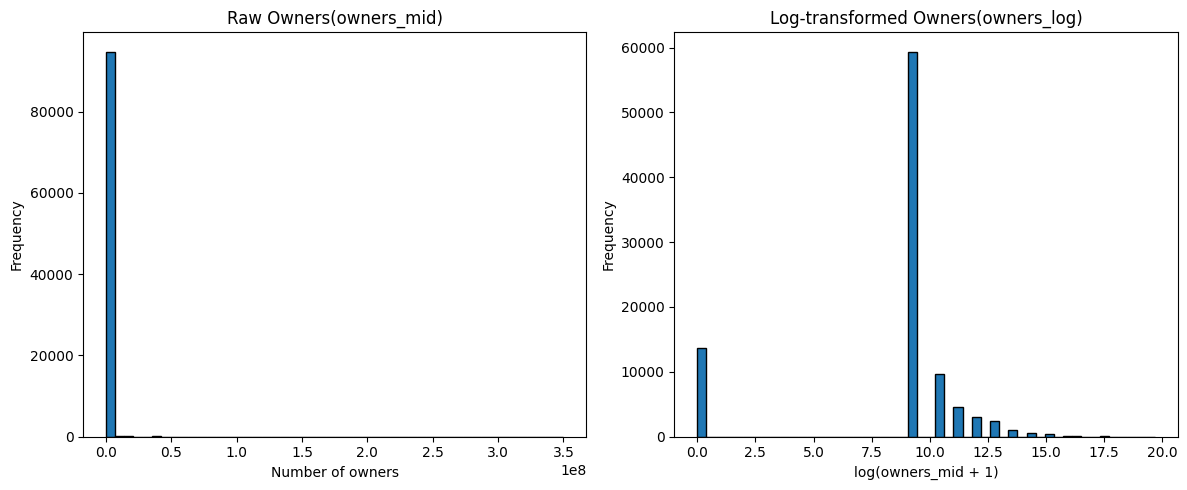

In [224]:
import matplotlib.pyplot as plt
def parse_owners(owners_str): 
    try: 
        low, high = owners_str.replace(",", "").split(" - ")
        return (int(low) + int(high)) // 2
    except: 
        return None

# 1. calculate owners_mid
df['owners_mid'] = df['estimated_owners'].apply(parse_owners)

# 2. log transform(adding +1 to avoid log(0))
df['owners_log'] = np.log1p(df['owners_mid'])

# 3. plot distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['owners_mid'].dropna(), bins=50, edgecolor='black')
plt.title('Raw Owners(owners_mid)')
plt.xlabel("Number of owners")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)
plt.hist(df['owners_log'].dropna(), bins=50, edgecolor='black')
plt.title('Log-transformed Owners(owners_log)')
plt.xlabel("log(owners_mid + 1)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

as we can clearly see, no big change is visible just a bit tweaked value, that's it. but we kind of normalised skeweness of the data. 

In [225]:
df=df.drop(columns=['owners_mid'], axis=1)

In [227]:
df=df.drop(columns=['estimated_owners'], axis=1)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94948 entries, 0 to 94947
Columns: 308 entries, appid to owners_log
dtypes: bool(3), float64(8), int32(3), int64(292), object(2)
memory usage: 220.1+ MB
